In [1]:
from scipy.misc import comb
import math

def ensemble_error(n_classifier, error):
    k_start = math.ceil(n_classifier/ 2.0)
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier- k)
            for k in range(k_start, n_classifier +1)]
    return sum(probs)

ensemble_error(n_classifier = 11, error = 0.25)

0.034327507019042969

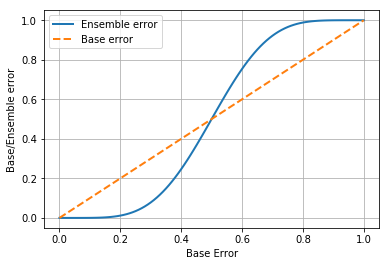

In [3]:
import numpy as np
error_range= np.arange(0.0,1.01,0.01)
ens_errors = [ensemble_error(n_classifier = 11, error = error) for error in error_range]
import matplotlib.pyplot as plt
plt.plot(error_range, ens_errors, label = 'Ensemble error', linewidth = 2)
plt.plot(error_range, error_range, linestyle = '--', label = 'Base error', linewidth = 2)
plt.xlabel('Base Error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc = 'upper left')
plt.grid()
plt.show()

In [5]:
ex = np.array([[0.9,0.1],[0.8,0.2],[0.4,0.6]])

In [6]:
p = np.average(ex, axis = 0, weights = [0.2, 0.2, 0.6])
p

array([ 0.58,  0.42])

In [7]:
help (np.average)

Help on function average in module numpy.lib.function_base:

average(a, axis=None, weights=None, returned=False)
    Compute the weighted average along the specified axis.
    
    Parameters
    ----------
    a : array_like
        Array containing data to be averaged. If `a` is not an array, a
        conversion is attempted.
    axis : int, optional
        Axis along which to average `a`. If `None`, averaging is done over
        the flattened array.
    weights : array_like, optional
        An array of weights associated with the values in `a`. Each value in
        `a` contributes to the average according to its associated weight.
        The weights array can either be 1-D (in which case its length must be
        the size of `a` along the given axis) or of the same shape as `a`.
        If `weights=None`, then all data in `a` are assumed to have a
        weight equal to one.
    returned : bool, optional
        Default is `False`. If `True`, the tuple (`average`, `sum_of_we

In [8]:
np.argmax(p)

0

In [9]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

In [35]:
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """ A majority vote ensemble classifier
    Parameter
    --------
    classifiers: array-like, shape = [n_classifiers]
    Different classifiers for the ensemble
    
    vote: str, {'classlabel', 'probability'}
    Default: 'class label'
    if 'classlabel' the prediction is based on the argmax of class labesl.
    Else if 'probability', the argmax of the sum of probabilities is used
    to predict the class label (recomended for calibarated classifiers).
    
    weights: array-like, shape = [n_classifiers]
    Optional, default: None
    if a list of 'int' or 'float' values are
    provided, the  classifiers are weighted by importance;
    Uses uniform weights if 'weight = None'.
    
    """
    
    def __init__(self, classifiers, vote = 'classlabel', weight = None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weight = weight
        
    def fit(self, x, y):
        """fit classifiers.
        
        Parameters
        ----------
        x: {array-like, sparse matrix},
        shape = [n_samples, n_features]
        Matrix of training samples.
        
        y: array-like, shape = [n_samples]
        vector of target class labels.
        
        Returns
        -------
        slef: object
        """
        # use labelEncoder to ensure class labels start
        # with 0, which is important for np.argmax
        # call in self.predict
        self.labelenc_ = LabelEncoder()
        self.labelenc_.fit(y)
        self.classes_ = self.labelenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(x, self.labelenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    
    
    def predict(self, x):
        """Predict class labels for x.
        
        Parameters
        ---------
        
        x: {arra-like, sparse matrix}, 
        shape = [n_samples, n_features]
        Matrix of training samples.
        
        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
        Predicted class labels.
        """
        
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(x), axis = 1)
        else: # 'class label' vote
            # collect results from clf.predict calls
            predictions = np.asarray([clf.predict[x] for clf in self.classifiers_]).T
            
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x,weights = self.weights)),
                                          axis = 1, arr = predictions)
            maj_vote = self.labenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, x):
        """Predict class probabilities for x.
        Parameters
        ----------
        
        x: {array-like, sparse matrix},
        shape = [n_samples, n_features]
        Training vectors, where n_samples is
        the number of samples and 
        n_features is the number of features
        
        Returns
        ---------
        avg_proba: array-like,
        shape = [n_samples, n_classes]
        Weighted average probability for 
        each class per sample
        """
        
        probas = np.asarray([clf.predict_proba(x) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis = 0, weights = self.weight)
        return avg_proba
    
    
    def get_params(self, deep = True):
        """Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep = False)
        
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep = True)):
                    out['%s__%s' % (name, key)] = value
            return out
        
        
        

In [14]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_iris
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = load_iris()
x, y = iris.data[50:,[1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [16]:
x_train,x_test, y_train, y_test = train_test_split(x, y, test_size = 0.5, random_state = 1)

Using the training dataset, we now will train three different classifiers-- a logistic regression clasifier, a decision tree classifier, and a k-nearest neighbors classifier -- and not at their individual perfromances via a 10-fold cross validation on the training dataset before we combine them into an ensembler classifier

In [17]:
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

In [18]:
clf1 = LogisticRegression(penalty = 'l2', C = 0.001, random_state = 0)
clf2 = DecisionTreeClassifier(max_depth = 1, criterion = 'entropy', random_state = 0)
clf3 = KNeighborsClassifier(n_neighbors = 1, p = 2, metric = 'minkowski')
pip1 = Pipeline([['sc', StandardScaler()], ['clf',clf1]])

In [22]:
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']
print ("10-fold cross validation: \n")
for clf, label in zip([pip1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator = clf, X = x_train, y = y_train, cv = 10, scoring = 'roc_auc')
    print ("Roc Auc %0.2f (+/- %0.2f) [%s]" %(scores.mean(), scores.std(), label))

10-fold cross validation: 

Roc Auc 0.92 (+/- 0.20) [Logistic Regression]
Roc Auc 0.92 (+/- 0.15) [Decision Tree]
Roc Auc 0.93 (+/- 0.10) [KNN]


In [36]:
mv_clf = MajorityVoteClassifier(classifiers = [pip1,clf2, pipe3])
clf_labels += ['Majority Voting']
all_clf = [pip1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator = clf, X= x_train, y = y_train, cv = 10, scoring = 'roc_auc')
    print ("Accuracy: %0.2f (+/- %0.2f) (%s)" % (scores.mean(), scores.std(),label))
    

Accuracy: 0.92 (+/- 0.20) (Logistic Regression)
Accuracy: 0.92 (+/- 0.15) (Decision Tree)
Accuracy: 0.93 (+/- 0.10) (KNN)
Accuracy: 0.97 (+/- 0.10) (Majority Voting)


In [37]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black', 'orange','blue', 'green']
linestyle = [':','--','-.','-']


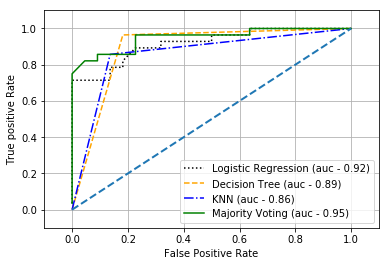

In [42]:
for clf, label, clr , ls in zip (all_clf,clf_labels, colors, linestyle):
    # assuming the label of the positive class is 1
    y_pred = clf.fit(x_train, y_train).predict_proba(x_test)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_true = y_test, y_score = y_pred)
    roc_auc = auc(x= fpr, y= tpr)
    plt.plot(fpr, tpr, color = clr, linestyle = ls, label = '%s (auc - %0.2f)' % (label, roc_auc))
    
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], linestyle = '--', linewidth = 2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel("True positive Rate")
plt.show()

In [43]:
sc = StandardScaler()
x_train_std = sc.fit_transform(x_train)
from itertools import product
x_min = x_train_std[:,0].min() - 1
x_max = x_train_std[:, 0].max() +1
y_min = x_train_std[:, 1].min() -1
y_max = x_train_std[:, 1].max() + 1

In [45]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f , axarr = plt.subplots(nrows = 2, ncols = 2, sharex = 'col', sharey = 'row', figsize = (7,5))
for idx, clf, tt in zip(product([0,1], [0,1]), all_clf, clf_labels):
    clf.fit(x_train_std, y_train)
    z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, z, alpha = 0.3)
    axarr[idx[0], idx[1]].scatter(x_train_std[y_train == 0, 0], x_train_std[y_train == 0, 1], c = 'blue',
                                 marker = '^', s = 50)
    axarr[idx[0], idx[1]].scatter(x_train_std[y_train == 1, 0], x_train_std[y_train == 1, 1], 
                                 c = 'red', marker = 'o', s = 50)
    axarr[idx[0], idx[1]].set_title(tt)
plt.text(-3.5,-4.5, s = 'Sepal width [standardized]', ha = 'center', va = 'center',
        fontisize = 12)
plt.text(-10.5, 4.5, s = 'petal length [standardized]', ha = 'center', va = 'center',
        fontsize = 12, rotation = 90)
plt.show()

TypeError: 'function' object is not subscriptable